In [7]:
import numpy as np
import torch
import pandas as pd
import odbo

## Get initial experiment design (temp using 2016 data, change to other experiments later)

In [8]:
# Load dataset
data_test = pd.read_csv('../datasets/GB1_2016_149361.csv', sep=',')
name_pre, Y_test = np.array(data_test['AACombo']), np.array(data_test['Fitness'])
name = odbo.utils.code_to_array(name_pre)
random_seed = 100
np.random.seed(random_seed)

# Let each site has 20 AA codes at least show up twice 
sele_indices = odbo.initialization.initial_design(name, least_occurance=[2,2,2,2],verbose = False)
# Inital experiments are selected to be name_sele with fitness of Y_sele
name_sele, Y_train = name[sele_indices, :], Y_test[sele_indices]
print('Selected initial experiments no. is ', len(sele_indices))

Selected initial experiments no. is  40


## Transform AA codes to average fitness feature 

In [9]:
# Using average measurement results as features
threshold = 0.05
feature_model = odbo.featurization.AvgMeasurement(raw_vars=name_sele, Y=Y_train)
X_train = feature_model.transform(name_sele)
X_test = feature_model.transform(name)

## Adapt search space construction

In [10]:
# Find the adaptive search space model
labels_train = odbo.prescreening.sp_label(X_train, Y_train, thres=threshold)
pre_model = odbo.prescreening.XGBOD(eval_metric = 'error')
pre_model.fit(X_train, labels_train)
pred_labels = pre_model.predict(X_train)
labels_test = odbo.prescreening.sp_label(X_test, Y_test, thres=threshold)
pred_test_labels = pre_model.predict(X_test)

/usr/local/lib/python3.7/site-packages/pyod/models/base.py:349: UserWarning: y should not be presented in unsupervised learning.
  "y should not be presented in unsupervised learning.")
/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Correct ratio: 85.973%
FN ratio: 7.282%
FP ratio: 6.745%


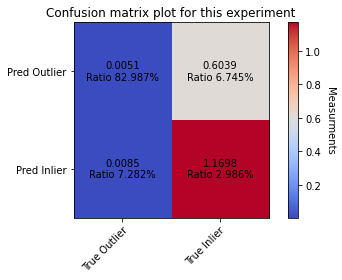

In [11]:
# Plot the confusion matrix to check the accuracy of search space prescreening
out_outlier, in_outlier, out_inlier, in_inlier = odbo.plot.plot_cm(labels_test, pred_test_labels, Y_test)
print("Correct ratio: {0:.3%}".format((len(out_outlier)+len(in_inlier))/len(labels_test)))
print("FN ratio: {0:.3%}".format(len(out_inlier)/len(labels_test)))
print("FP ratio: {0:.3%}".format(len(in_outlier)/len(labels_test)))  

## BO for next best experiment

In [ ]:
# Pick the Top 40 init experiment from the 384 experiments
sele_id = np.argsort(Y_train)[-40:]
X_train_sele, Y_train_sele = torch.tensor(X_train[sele_id, :]), torch.tensor(Y_train[sele_id].reshape(40,1))
# Only search the space after prescreening
sele_id_test = []
sele_id_test.extend(in_inlier)
sele_id_test.extend(out_inlier)
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
print(X_train_sele.shape, Y_train_sele.shape, X_test_sele.shape, Y_test_sele.shape)

## Run BO experiment with robust regression or directly gp
l, search_iter = 0, 50
batch_size = 1
gp_method='gp_regression'
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy())
    X_next, acq_value, next_exp_id = odbo.bo_design(X=X_train_sele, Y=Y_train_sele, X_pending=X_test_sele, gp_method=gp_method, batch_size=batch_size)
    ids_keep = list(np.delete(range(X_test_sele.shape[0]), next_exp_id))
    X_train_sele, Y_train_sele = torch.cat([X_train_sele, X_test_sele[next_exp_id, :]]), torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    X_test_sele, Y_test_sele = X_test_sele[ids_keep, :], Y_test_sele[ids_keep]
    print("Newly added value: ", Y_train_sele[-batch_size:].detach().numpy())
    l = l + 1



torch.Size([40, 4]) torch.Size([40, 1]) torch.Size([15336, 4]) torch.Size([15336, 1])
Iter:  0 Current Max:  3.147576643
Newly added value:  [[1.37803514]]
Iter:  1 Current Max:  3.147576643
Newly added value:  [[1.16494146]]
Iter:  2 Current Max:  3.147576643
Newly added value:  [[0.62291667]]
Iter:  3 Current Max:  3.147576643
Newly added value:  [[4.72770043]]
Iter:  4 Current Max:  4.727700429
Newly added value:  [[0.02592185]]
Iter:  5 Current Max:  4.727700429
Newly added value:  [[4.26716358]]
Iter:  6 Current Max:  4.727700429
Newly added value:  [[3.28869275]]
Iter:  7 Current Max:  4.727700429
Newly added value:  [[2.88134356]]
Iter:  8 Current Max:  4.727700429
Newly added value:  [[0.30952674]]
Iter:  9 Current Max:  4.727700429
Newly added value:  [[2.0357201]]
Iter:  10 Current Max:  4.727700429
Newly added value:  [[0.01626979]]
Iter:  11 Current Max:  4.727700429
Newly added value:  [[0.03559524]]
Iter:  12 Current Max:  4.727700429
Newly added value:  [[1.77942029]]
It

## TurBO for next best experiment

In [ ]:
# Pick the Top 40 init experiment from the 384 experiments
sele_id = np.argsort(Y_train)[-40:]
X_train_sele, Y_train_sele = torch.tensor(X_train[sele_id, :]), torch.tensor(Y_train[sele_id].reshape(40,1))
# Only search the space after prescreening
sele_id_test = []
sele_id_test.extend(in_inlier)
sele_id_test.extend(out_inlier)
X_test_sele, Y_test_sele = torch.tensor(X_test[sele_id_test, :]), torch.tensor(Y_test[sele_id_test].reshape(len(sele_id_test),1))
print(X_train_sele.shape, Y_train_sele.shape, X_test_sele.shape, Y_test_sele.shape)

# Run BO experiment with robust regression or directly gp
l, search_iter = 0, 50
gp_method='robust_regression'
tr_length = [3.2]
batch_size = 1
state = odbo.turbo.TurboState(dim=X_train_sele.shape[1], batch_size=batch_size, length=tr_length, n_trust_regions=len(tr_length), failure_tolerance = 10)
state.best_value = Y_train_sele.max()
while l < search_iter:
    print("Iter: ", l, "Current Max: ", Y_train_sele.max().detach().numpy(), 'TR length: ', state.length)
    X_next, acq_value, raw_next_exp_id = odbo.turbo_design(state=state, X=X_train_sele, Y=Y_train_sele, X_pending=X_test_sele, n_trust_regions=len(tr_length), batch_size=batch_size, gp_method=gp_method)
    Y_next_m = torch.zeros((len(tr_length), batch_size, 1), device=Y_train_sele.device, dtype=Y_train_sele.dtype)
    next_exp_id = []
    for i in range(batch_size):
        next_exp_id_m = raw_next_exp_id[:, i]
        idtoadd = next_exp_id_m[np.argmax(Y_test_sele[next_exp_id_m])]
        next_exp_id.append(idtoadd)
        Y_next_m[:, i, 0] = Y_test_sele[next_exp_id_m]
    X_train_sele, Y_train_sele = torch.cat([X_train_sele, X_test_sele[next_exp_id, :]]), torch.cat([Y_train_sele, Y_test_sele[next_exp_id]])
    ids_keep = list(np.delete(range(X_test_sele.shape[0]), next_exp_id))
    X_test_sele, Y_test_sele = X_test_sele[ids_keep, :], Y_test_sele[ids_keep]
    print("Newly added value: ", Y_train_sele[-batch_size:].detach().numpy())
    state = odbo.turbo.update_state(state=state, Y_next=Y_next_m)
    l = l + 1

